## REXIA - TP1 : Données tabulaires  

### DEBRAY Clarisse & GLERANT Pierre  
##### clarisse.debray@student-cs.fr -  pierre.glerant@student-cs.fr  

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pygam import LogisticGAM, s

In [2]:
path = "dataset_RH.pkl"

In [3]:
X = pd.read_pickle(path)[0]
y = pd.read_pickle(path)[1]

df = X.copy()
df["demission"] = y

### 1) Analyse du jeu de données 

In [4]:
# Infos globales
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23857 entries, 0 to 23856
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Famille d'emploi              23857 non-null  object 
 1   Dernière promotion (mois)     23857 non-null  float64
 2   Dernière augmentation (mois)  23857 non-null  float64
 3   Début de contrat (années)     23857 non-null  float64
 4   Ancienneté groupe (années)    23857 non-null  float64
 5   Etablissement                 23857 non-null  int64  
 6   Âge (années)                  23857 non-null  int64  
 7   Parent                        23857 non-null  int64  
 8   Niveau hiérarchique           23857 non-null  int64  
 9   Salaire (Euros)               23857 non-null  int64  
 10  Statut marital                23857 non-null  object 
 11  Véhicule                      23857 non-null  int64  
 12  matricule                     23857 non-null  int64  
dtypes

In [5]:
# Nombre de valeurs manquantes par colonnes
print(X.isnull().sum())

Famille d'emploi                0
Dernière promotion (mois)       0
Dernière augmentation (mois)    0
Début de contrat (années)       0
Ancienneté groupe (années)      0
Etablissement                   0
Âge (années)                    0
Parent                          0
Niveau hiérarchique             0
Salaire (Euros)                 0
Statut marital                  0
Véhicule                        0
matricule                       0
dtype: int64


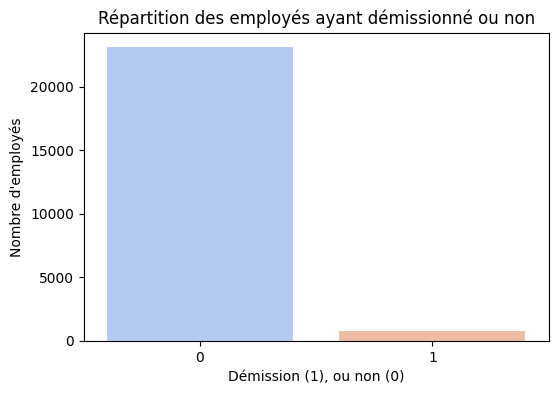

In [6]:
# Distribution variable cible
plt.figure(figsize=(6, 4))
sns.countplot(x="demission", data=df, palette="coolwarm")
plt.title("Répartition des employés ayant démissionné ou non")
plt.xlabel("Démission (1), ou non (0)")
plt.ylabel("Nombre d'employés")
plt.show()


Il y a 755 personnes ayant démissionné contre 23 102 qui sont toujours dans l'entreprise. Respectivement 3% et 97% du dataset, nous avons donc une grande disparité qu'il faudra prendre en compte dans la modélisation voire le pré processing.

In [7]:
# Analyse de parcours d'un employé qui a démissionné et un autre qui est resté
dem = df[df["demission"] == 1].sample(1, random_state=42)
res = df[df["demission"] == 0].sample(1, random_state=42)
comp = pd.concat([dem, res])
comp


,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule,demission
9416,Etudes & Technique,25.559999,4.54,3.22,3.31,26,29,0,1,2752,Union libre,0,17,1
22854,Support,9.370000,4.78,2.30,2.45,28,31,1,1,3283,Marié(e),0,1163,0


Ces deux profils se ressemblent par leur situation personnelle excepté la parentalité (le démissionnaire n'a pas d'enfants). Cependant, les points qui se dissocient le plus sont le salaire mais surtout la date de dernière promotion même si la dernière augmentation reste presque équivalente.

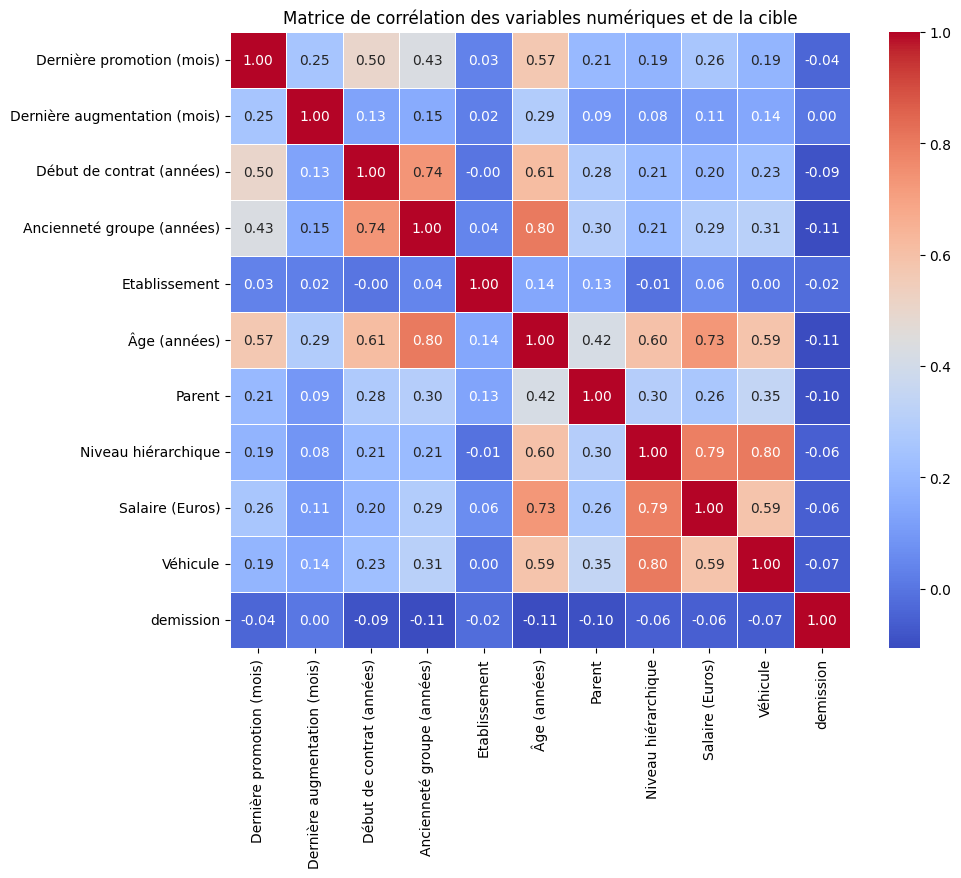

In [8]:
#matrice de correlation
X_numeric = df.drop(columns=["Famille d'emploi", "Statut marital", "matricule"])
plt.figure(figsize=(10, 8))
corr_matrix = X_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques et de la cible")
plt.show()

Sans grande surprise, nous remarquons une grande corrélation entre l'âge, l'ancienneté, le salaire et le niveau hiérarchique. De plus, on voit que la cible de l'étude n'est correllée avec aucune donnée : l'étude est donc justifiée car une seule colonne ne donne pas directement l'indication de la démission.

### 2) Apprentissage automatique

#### 2.1) Choix des modèles transparents

* Regression logistique : basique, rapide et facilement interprétable et gère les données déséquilibrées
* Decision Tree : Facilement interprétable et gère les données déséquilibrées 
* GAM : Facilement interprétable et visualisable

#### 2.2) Preprocessing global

In [9]:
#Le matricule correspond à l'id de l'employé et donc ne donne aucune info sur la démission
X = X.drop(columns=['matricule'])

#Dummy des var cat
X = pd.get_dummies(X).astype(int)

#normalisation
scaler = StandardScaler()
X_norm= scaler.fit_transform(X)


#### 2.3) Regression logistique

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logreg_model = LogisticRegression(class_weight='balanced', random_state=42)
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
y_prob = logreg_model.predict_proba(X_test)[:, 1]

In [11]:
roc_auc_score(y_test, y_prob)

0.6631631294507797

#### 2.4) Decision Tree

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dt_model = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)[:, 1]

In [13]:
roc_auc_score(y_test, y_prob)

0.7160321939432852

#### 2.5) GAM

In [22]:

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialiser le premier terme avec s(0)
terms = s(0)
# Ajouter les autres termes pour les features restantes
for i in range(1, X_train.shape[1]):
    terms += s(i)

# Convertir le DataFrame en numpy array pour éviter des problèmes d'indexation
gam = LogisticGAM(terms).gridsearch(X_train.to_numpy(), y_train)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:51 ETA:   0:08:33
 18% (2 of 11) |####                     | Elapsed Time: 0:01:02 ETA:   0:04:41
 27% (3 of 11) |######                   | Elapsed Time: 0:01:14 ETA:   0:03:17
 36% (4 of 11) |#########                | Elapsed Time: 0:01:26 ETA:   0:02:30
 45% (5 of 11) |###########              | Elapsed Time: 0:01:38 ETA:   0:01:58
 54% (6 of 11) |#############            | Elapsed Time: 0:01:50 ETA:   0:01:32
 63% (7 of 11) |###############          | Elapsed Time: 0:02:01 ETA:   0:01:09
 72% (8 of 11) |##################       | Elapsed Time: 0:02:12 ETA:   0:00:49
 81% (9 of 11) |####################     | Elapsed Time: 0:02:23 ETA:   0:00:31
 90% (10 of 11) |#####################   | Elapsed Time: 0:02:34 ETA:   0:00:15
100% (11 of 11) |########################| Elapsed Time: 0:02:45 Time:  0:02:45


In [23]:
y_prob_gam = gam.predict_proba(X_test)

auc_gam = roc_auc_score(y_test, y_prob_gam)
print("AUC GAM:", auc_gam)

AUC GAM: 0.72103885085508
